<a href="https://colab.research.google.com/github/itinasharma/MachineLearning/blob/main/confidence_divergence_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Why accuracy is not enough?**



MODEL COMPARISON
----------------
Model A | Accuracy: 0.900, Loss: 0.378, Brier: 0.110
Model B | Accuracy: 0.912, Loss: 0.245, Brier: 0.073


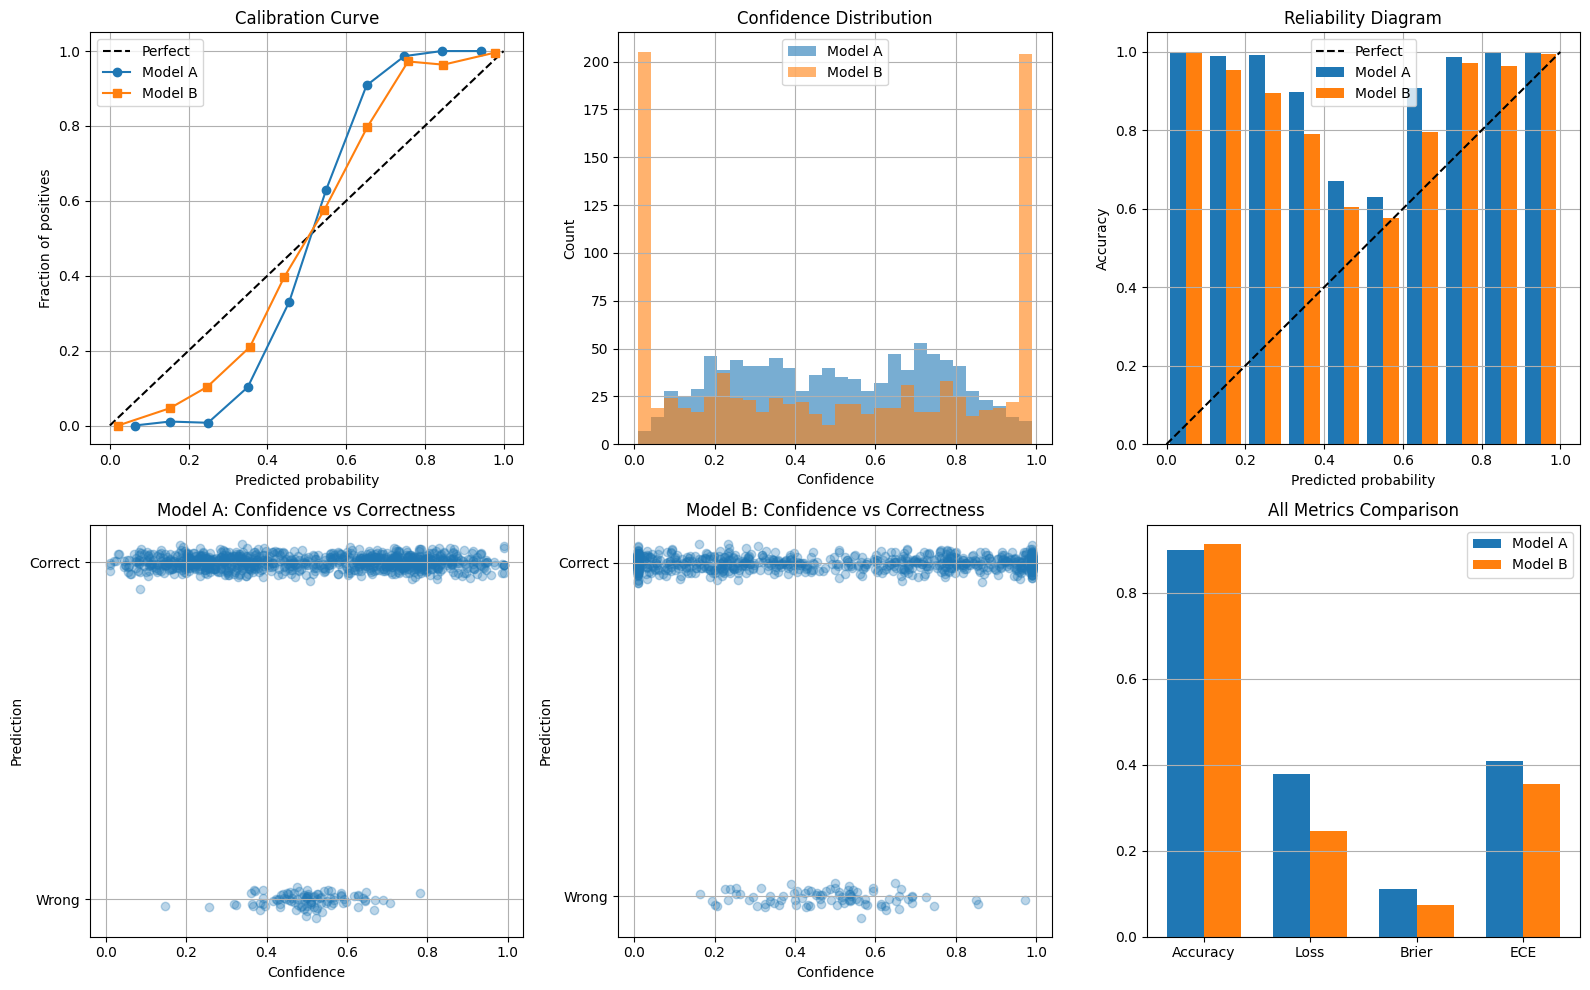

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss

# --------------------------------------------------
# Setup
# --------------------------------------------------

np.random.seed(42)

n_samples = 1000
true_labels = np.random.binomial(1, 0.5, n_samples)


# --------------------------------------------------
# Model A: well calibrated
# --------------------------------------------------

def generate_model_a_predictions(true_labels):
    predictions = []
    confidences = []

    for label in true_labels:
        if label == 1:
            prob = np.random.beta(7, 3)
        else:
            prob = np.random.beta(3, 7)

        prob = np.clip(prob + np.random.normal(0, 0.05), 0.01, 0.99)

        confidences.append(prob)
        predictions.append(1 if prob > 0.5 else 0)

    return np.array(predictions), np.array(confidences)


# --------------------------------------------------
# Model B: overconfident
# --------------------------------------------------

def generate_model_b_predictions(true_labels):
    predictions = []
    confidences = []

    for label in true_labels:
        if label == 1:
            prob = np.random.beta(7, 3)
        else:
            prob = np.random.beta(3, 7)

        if prob > 0.5:
            prob = 0.5 + (prob - 0.5) * 1.8
        else:
            prob = 0.5 - (0.5 - prob) * 1.8

        prob = np.clip(prob, 0.01, 0.99)

        confidences.append(prob)
        predictions.append(1 if prob > 0.5 else 0)

    return np.array(predictions), np.array(confidences)


# --------------------------------------------------
# Generate predictions
# --------------------------------------------------

pred_a, conf_a = generate_model_a_predictions(true_labels)
pred_b, conf_b = generate_model_b_predictions(true_labels)


# --------------------------------------------------
# Metrics
# --------------------------------------------------

acc_a = accuracy_score(true_labels, pred_a)
acc_b = accuracy_score(true_labels, pred_b)

loss_a = log_loss(true_labels, conf_a)
loss_b = log_loss(true_labels, conf_b)

brier_a = brier_score_loss(true_labels, conf_a)
brier_b = brier_score_loss(true_labels, conf_b)

print("MODEL COMPARISON")
print("----------------")
print(f"Model A | Accuracy: {acc_a:.3f}, Loss: {loss_a:.3f}, Brier: {brier_a:.3f}")
print(f"Model B | Accuracy: {acc_b:.3f}, Loss: {loss_b:.3f}, Brier: {brier_b:.3f}")


# --------------------------------------------------
# Plots
# --------------------------------------------------

fig = plt.figure(figsize=(16, 10))

# 1. Calibration curve
ax1 = plt.subplot(2, 3, 1)

frac_a, mean_a = calibration_curve(true_labels, conf_a, n_bins=10)
frac_b, mean_b = calibration_curve(true_labels, conf_b, n_bins=10)

plt.plot([0, 1], [0, 1], "k--", label="Perfect")
plt.plot(mean_a, frac_a, "o-", label="Model A")
plt.plot(mean_b, frac_b, "s-", label="Model B")

plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)


# 2. Confidence distribution
ax2 = plt.subplot(2, 3, 2)

plt.hist(conf_a, bins=30, alpha=0.6, label="Model A")
plt.hist(conf_b, bins=30, alpha=0.6, label="Model B")

plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution")
plt.legend()
plt.grid(True)


# 3. Reliability diagram
ax3 = plt.subplot(2, 3, 3)

bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2

acc_bins_a = []
acc_bins_b = []

for i in range(len(bins) - 1):
    mask_a = (conf_a >= bins[i]) & (conf_a < bins[i + 1])
    mask_b = (conf_b >= bins[i]) & (conf_b < bins[i + 1])

    acc_bins_a.append(
        (pred_a[mask_a] == true_labels[mask_a]).mean()
        if mask_a.sum() > 0 else 0
    )

    acc_bins_b.append(
        (pred_b[mask_b] == true_labels[mask_b]).mean()
        if mask_b.sum() > 0 else 0
    )

width = 0.04

plt.bar(bin_centers - width / 2, acc_bins_a, width, label="Model A")
plt.bar(bin_centers + width / 2, acc_bins_b, width, label="Model B")
plt.plot([0, 1], [0, 1], "k--", label="Perfect")

plt.xlabel("Predicted probability")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)


# 4. Model A: confidence vs correctness
ax4 = plt.subplot(2, 3, 4)

correct_a = pred_a == true_labels
jitter_a = np.random.normal(0, 0.02, len(conf_a))

plt.scatter(conf_a, correct_a + jitter_a, alpha=0.3)
plt.yticks([0, 1], ["Wrong", "Correct"])
plt.xlabel("Confidence")
plt.ylabel("Prediction")
plt.title("Model A: Confidence vs Correctness")
plt.grid(True)


# 5. Model B: confidence vs correctness
ax5 = plt.subplot(2, 3, 5)

correct_b = pred_b == true_labels
jitter_b = np.random.normal(0, 0.02, len(conf_b))

plt.scatter(conf_b, correct_b + jitter_b, alpha=0.3)
plt.yticks([0, 1], ["Wrong", "Correct"])
plt.xlabel("Confidence")
plt.ylabel("Prediction")
plt.title("Model B: Confidence vs Correctness")
plt.grid(True)


# 6. All metrics comparison
ax6 = plt.subplot(2, 3, 6)

ece_a = np.abs(np.array(acc_bins_a) - bin_centers).mean()
ece_b = np.abs(np.array(acc_bins_b) - bin_centers).mean()

metrics = ["Accuracy", "Loss", "Brier", "ECE"]
vals_a = [acc_a, loss_a, brier_a, ece_a]
vals_b = [acc_b, loss_b, brier_b, ece_b]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, vals_a, width, label="Model A")
plt.bar(x + width / 2, vals_b, width, label="Model B")

plt.xticks(x, metrics)
plt.title("All Metrics Comparison")
plt.legend()
plt.grid(True, axis="y")


plt.tight_layout()
plt.savefig("calibration_analysis.png", dpi=300)
plt.show()


## **Why divergence is the right thing instead?**


THE HIDDEN CONNECTION: Cross-Entropy = Entropy + KL Divergence

Distribution P (truth):     [0.7 0.3]
Distribution Q (model):     [0.6 0.4]

Cross-Entropy H(P, Q):      0.632465
Entropy H(P):               0.610864
KL Divergence D_KL(P || Q): 0.021601

H(P) + D_KL(P || Q):        0.632465

✓ Match! Cross-Entropy = Entropy + KL Divergence

WHY THIS MATTERS: Minimizing Cross-Entropy = Minimizing KL Divergence

True distribution P: [0.8 0.2]
Entropy H(P): 0.500402 (constant!)

--------------------------------------------------------------------------------
Model           Cross-Ent    KL Div       H(P) + KL    Match?    
--------------------------------------------------------------------------------
Untrained         0.693147    0.192745    0.693147         ✓
Early             0.554591    0.054188    0.554591         ✓
Mid               0.507405    0.007002    0.507405         ✓
Late              0.500707    0.000305    0.500707         ✓
Converged         0.500402    0.000000    0.50040

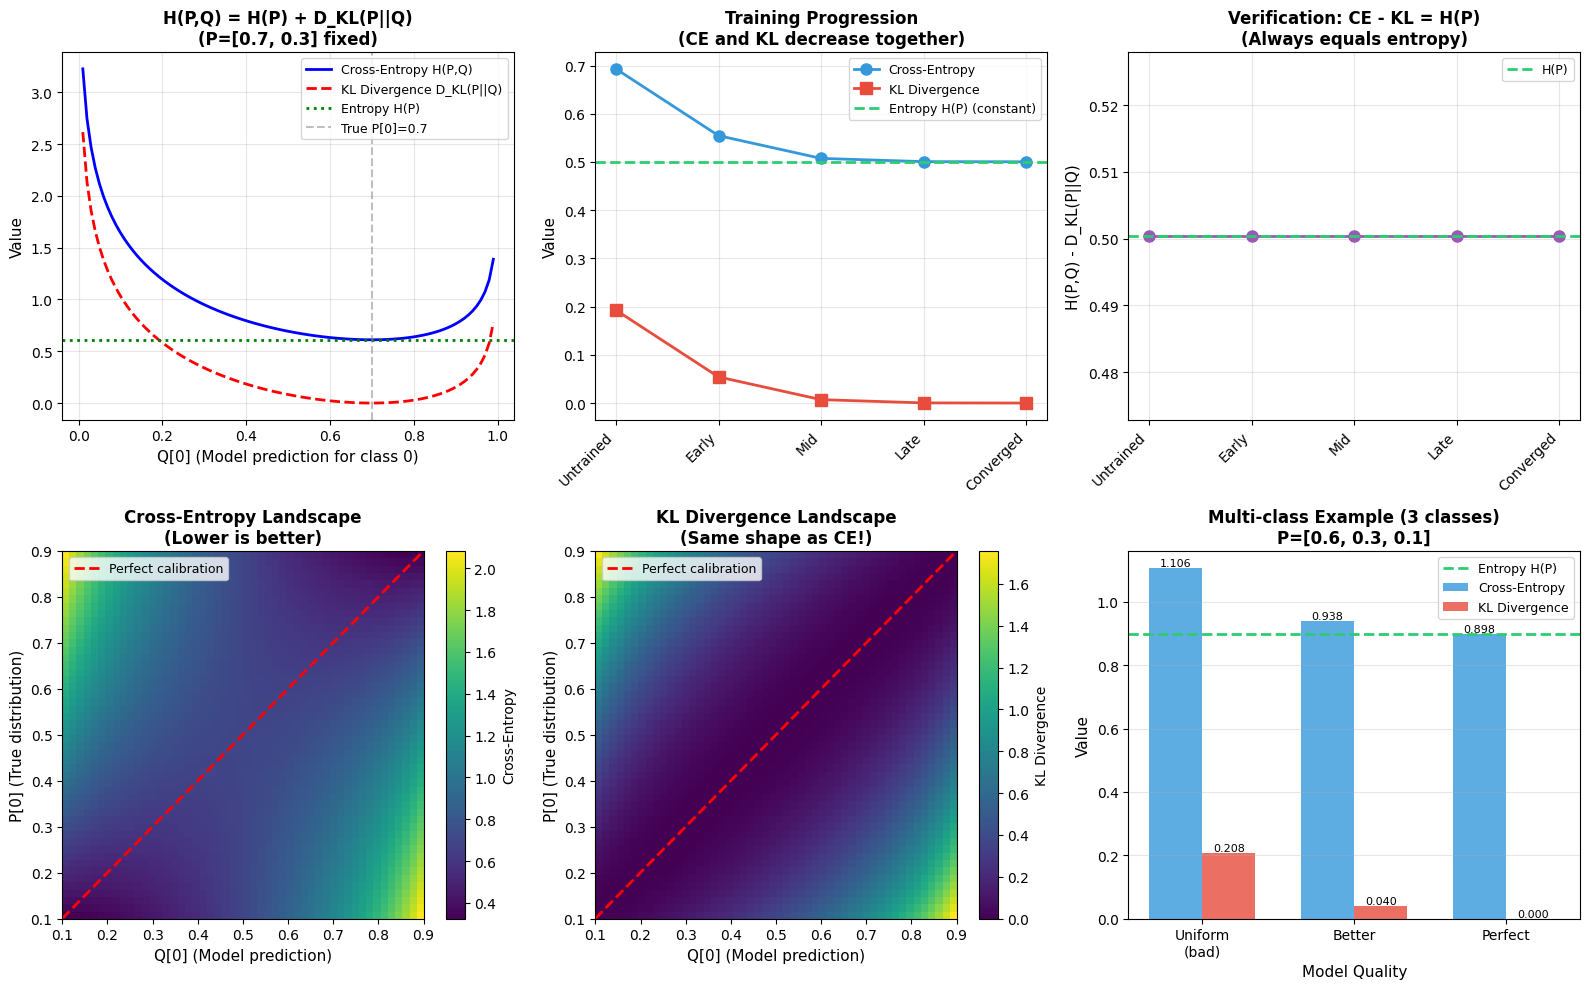


PRACTICAL IMPLICATIONS FOR ML

1. LOSS FUNCTION CHOICE:
   When you use cross-entropy loss for classification, you're implicitly
   minimizing the KL divergence between true and predicted distributions.
   
2. WHY IT WORKS:
   • H(P) is constant (true labels don't change)
   • Minimizing H(P,Q) = minimizing D_KL(P||Q)
   • KL divergence is the "right" measure for comparing distributions
   
3. INTUITION:
   • Cross-entropy: "What's the average surprise?"
   • KL divergence: "How much information is lost?"
   • They differ by a constant (the entropy of true distribution)
   
4. CALIBRATION CONNECTION:
   • Well-calibrated models have low KL divergence
   • Overconfident models can have low loss but poor calibration
   • This is why ECE (Expected Calibration Error) is a better metric!
   
5. THE FORMULA:
   
   H(P, Q) = H(P) + D_KL(P || Q)
   
   Cross-Entropy = Entropy + KL Divergence
   
   Since H(P) is constant during training:
   
   argmin_Q H(P, Q) = argmin_Q D_KL(P || Q)
   
  

In [ ]:
"""
The Hidden Connection: Cross-Entropy is KL Divergence

This script proves that when you minimize cross-entropy loss during training,
you're actually minimizing KL divergence. The connection is:

    H(P, Q) = H(P) + D_KL(P || Q)

Since H(P) is constant during training (true labels don't change),
minimizing cross-entropy is equivalent to minimizing KL divergence.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)

# ==============================================================================
# PART 1: THE MATHEMATICAL CONNECTION
# ==============================================================================

def cross_entropy(P, Q):
    """
    Cross-entropy: H(P, Q) = -Σ P(x) log Q(x)
    Measures the average number of bits needed to encode data from P using Q
    """
    return -np.sum(P * np.log(np.clip(Q, 1e-15, 1)))

def entropy_H(P):
    """
    Entropy: H(P) = -Σ P(x) log P(x)
    Measures the inherent uncertainty in distribution P
    """
    return -np.sum(P * np.log(np.clip(P, 1e-15, 1)))

def kl_divergence(P, Q):
    """
    KL Divergence: D_KL(P || Q) = Σ P(x) log(P(x) / Q(x))
    Measures information lost when using Q to approximate P
    """
    return np.sum(P * np.log(np.clip(P / Q, 1e-15, 1e15)))

# Example distributions
print("=" * 80)
print("THE HIDDEN CONNECTION: Cross-Entropy = Entropy + KL Divergence")
print("=" * 80)

# True distribution (e.g., one-hot encoded labels)
P = np.array([0.7, 0.3])  # True class probabilities

# Model distribution (predicted probabilities)
Q = np.array([0.6, 0.4])  # Model predictions

ce = cross_entropy(P, Q)
h = entropy_H(P)
kl = kl_divergence(P, Q)

print(f"\nDistribution P (truth):     {P}")
print(f"Distribution Q (model):     {Q}")
print(f"\nCross-Entropy H(P, Q):      {ce:.6f}")
print(f"Entropy H(P):               {h:.6f}")
print(f"KL Divergence D_KL(P || Q): {kl:.6f}")
print(f"\nH(P) + D_KL(P || Q):        {(h + kl):.6f}")
print(f"\n✓ Match! Cross-Entropy = Entropy + KL Divergence")

# ==============================================================================
# PART 2: WHY THIS MATTERS FOR TRAINING
# ==============================================================================

print("\n" + "=" * 80)
print("WHY THIS MATTERS: Minimizing Cross-Entropy = Minimizing KL Divergence")
print("=" * 80)

# Fixed true distribution (labels don't change during training)
P_true = np.array([0.8, 0.2])

# Different model predictions (as training progresses)
Q_models = [
    np.array([0.5, 0.5]),   # Untrained (uniform)
    np.array([0.65, 0.35]),  # Early training
    np.array([0.75, 0.25]),  # Mid training
    np.array([0.79, 0.21]),  # Late training
    np.array([0.80, 0.20]),  # Converged
]

model_names = ["Untrained", "Early", "Mid", "Late", "Converged"]

print(f"\nTrue distribution P: {P_true}")
print(f"Entropy H(P): {entropy_H(P_true):.6f} (constant!)")
print("\n" + "-" * 80)
print(f"{'Model':<15} {'Cross-Ent':<12} {'KL Div':<12} {'H(P) + KL':<12} {'Match?':<10}")
print("-" * 80)

for name, Q in zip(model_names, Q_models):
    ce = cross_entropy(P_true, Q)
    kl = kl_divergence(P_true, Q)
    h_p = entropy_H(P_true)
    total = h_p + kl
    match = "✓" if abs(ce - total) < 1e-10 else "✗"
    print(f"{name:<15} {ce:>10.6f}  {kl:>10.6f}  {total:>10.6f}  {match:>8}")

print("-" * 80)
print("\nKey Insight: As training progresses:")
print("  • Cross-entropy decreases")
print("  • KL divergence decreases (by the same amount!)")
print("  • Entropy H(P) stays constant")
print("\n  → Minimizing cross-entropy = minimizing KL divergence!")

# ==============================================================================
# PART 3: VISUALIZING THE CONNECTION
# ==============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION: Creating plots...")
print("=" * 80)

fig = plt.figure(figsize=(16, 10))

# Plot 1: The relationship for a specific example
ax1 = plt.subplot(2, 3, 1)
P_fixed = np.array([0.7, 0.3])
Q_range = np.linspace(0.01, 0.99, 100)
ce_vals = []
kl_vals = []
h_p_val = entropy_H(P_fixed)

for q0 in Q_range:
    Q_temp = np.array([q0, 1 - q0])
    ce_vals.append(cross_entropy(P_fixed, Q_temp))
    kl_vals.append(kl_divergence(P_fixed, Q_temp))

plt.plot(Q_range, ce_vals, 'b-', linewidth=2, label='Cross-Entropy H(P,Q)')
plt.plot(Q_range, kl_vals, 'r--', linewidth=2, label='KL Divergence D_KL(P||Q)')
plt.axhline(y=h_p_val, color='g', linestyle=':', linewidth=2, label='Entropy H(P)')
plt.axvline(x=P_fixed[0], color='gray', linestyle='--', alpha=0.5, label='True P[0]=0.7')
plt.xlabel('Q[0] (Model prediction for class 0)', fontsize=11)
plt.ylabel('Value', fontsize=11)
plt.title('H(P,Q) = H(P) + D_KL(P||Q)\n(P=[0.7, 0.3] fixed)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# Plot 2: Training progression visualization
ax2 = plt.subplot(2, 3, 2)
epochs = range(len(Q_models))
ce_progression = [cross_entropy(P_true, Q) for Q in Q_models]
kl_progression = [kl_divergence(P_true, Q) for Q in Q_models]
h_p_progression = [entropy_H(P_true)] * len(Q_models)

plt.plot(epochs, ce_progression, 'o-', linewidth=2, markersize=8, label='Cross-Entropy', color='#3498db')
plt.plot(epochs, kl_progression, 's-', linewidth=2, markersize=8, label='KL Divergence', color='#e74c3c')
plt.axhline(y=entropy_H(P_true), color='#2ecc71', linestyle='--', linewidth=2, label='Entropy H(P) (constant)')
plt.xticks(epochs, model_names, rotation=45, ha='right')
plt.ylabel('Value', fontsize=11)
plt.title('Training Progression\n(CE and KL decrease together)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# Plot 3: Difference verification
ax3 = plt.subplot(2, 3, 3)
differences = [ce_progression[i] - kl_progression[i] for i in range(len(ce_progression))]
plt.plot(epochs, differences, 'o-', linewidth=2, markersize=8, color='#9b59b6')
plt.axhline(y=entropy_H(P_true), color='#2ecc71', linestyle='--', linewidth=2, label='H(P)')
plt.xticks(epochs, model_names, rotation=45, ha='right')
plt.ylabel('H(P,Q) - D_KL(P||Q)', fontsize=11)
plt.title('Verification: CE - KL = H(P)\n(Always equals entropy)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# Plot 4: Heatmap showing relationship for various P and Q
ax4 = plt.subplot(2, 3, 4)
p_vals = np.linspace(0.1, 0.9, 50)
q_vals = np.linspace(0.1, 0.9, 50)
ce_grid = np.zeros((len(p_vals), len(q_vals)))

for i, p0 in enumerate(p_vals):
    for j, q0 in enumerate(q_vals):
        P_temp = np.array([p0, 1 - p0])
        Q_temp = np.array([q0, 1 - q0])
        ce_grid[i, j] = cross_entropy(P_temp, Q_temp)

im = plt.imshow(ce_grid, extent=[0.1, 0.9, 0.1, 0.9], origin='lower',
                aspect='auto', cmap='viridis')
plt.colorbar(im, label='Cross-Entropy')
plt.xlabel('Q[0] (Model prediction)', fontsize=11)
plt.ylabel('P[0] (True distribution)', fontsize=11)
plt.title('Cross-Entropy Landscape\n(Lower is better)', fontsize=12, fontweight='bold')
plt.plot([0.1, 0.9], [0.1, 0.9], 'r--', linewidth=2, label='Perfect calibration')
plt.legend(fontsize=9)

# Plot 5: KL divergence heatmap
ax5 = plt.subplot(2, 3, 5)
kl_grid = np.zeros((len(p_vals), len(q_vals)))

for i, p0 in enumerate(p_vals):
    for j, q0 in enumerate(q_vals):
        P_temp = np.array([p0, 1 - p0])
        Q_temp = np.array([q0, 1 - q0])
        kl_grid[i, j] = kl_divergence(P_temp, Q_temp)

im = plt.imshow(kl_grid, extent=[0.1, 0.9, 0.1, 0.9], origin='lower',
                aspect='auto', cmap='viridis')
plt.colorbar(im, label='KL Divergence')
plt.xlabel('Q[0] (Model prediction)', fontsize=11)
plt.ylabel('P[0] (True distribution)', fontsize=11)
plt.title('KL Divergence Landscape\n(Same shape as CE!)', fontsize=12, fontweight='bold')
plt.plot([0.1, 0.9], [0.1, 0.9], 'r--', linewidth=2, label='Perfect calibration')
plt.legend(fontsize=9)

# Plot 6: Multi-class example
ax6 = plt.subplot(2, 3, 6)
# 3-class example
n_classes = 3
P_multi = np.array([0.6, 0.3, 0.1])  # True distribution

# Different model predictions
Q_multi_models = [
    np.array([0.33, 0.33, 0.34]),  # Uniform
    np.array([0.5, 0.3, 0.2]),      # Getting better
    np.array([0.6, 0.3, 0.1]),      # Perfect
]

labels = ['Uniform\n(bad)', 'Better', 'Perfect']
ce_multi = [cross_entropy(P_multi, Q) for Q in Q_multi_models]
kl_multi = [kl_divergence(P_multi, Q) for Q in Q_multi_models]
h_p_multi = entropy_H(P_multi)

x = np.arange(len(labels))
width = 0.35

bars1 = plt.bar(x - width/2, ce_multi, width, label='Cross-Entropy', color='#3498db', alpha=0.8)
bars2 = plt.bar(x + width/2, kl_multi, width, label='KL Divergence', color='#e74c3c', alpha=0.8)
plt.axhline(y=h_p_multi, color='#2ecc71', linestyle='--', linewidth=2, label='Entropy H(P)')

plt.xlabel('Model Quality', fontsize=11)
plt.ylabel('Value', fontsize=11)
plt.title('Multi-class Example (3 classes)\nP=[0.6, 0.3, 0.1]', fontsize=12, fontweight='bold')
plt.xticks(x, labels)
plt.legend(fontsize=9)
plt.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('cross_entropy_kl_connection.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'cross_entropy_kl_connection.png'")
plt.show()

# ==============================================================================
# PART 4: PRACTICAL IMPLICATIONS
# ==============================================================================

print("\n" + "=" * 80)
print("PRACTICAL IMPLICATIONS FOR ML")
print("=" * 80)

print("""
1. LOSS FUNCTION CHOICE:
   When you use cross-entropy loss for classification, you're implicitly
   minimizing the KL divergence between true and predicted distributions.

2. WHY IT WORKS:
   • H(P) is constant (true labels don't change)
   • Minimizing H(P,Q) = minimizing D_KL(P||Q)
   • KL divergence is the "right" measure for comparing distributions

3. INTUITION:
   • Cross-entropy: "What's the average surprise?"
   • KL divergence: "How much information is lost?"
   • They differ by a constant (the entropy of true distribution)

4. CALIBRATION CONNECTION:
   • Well-calibrated models have low KL divergence
   • Overconfident models can have low loss but poor calibration
   • This is why ECE (Expected Calibration Error) is a better metric!

5. THE FORMULA:

   H(P, Q) = H(P) + D_KL(P || Q)

   Cross-Entropy = Entropy + KL Divergence

   Since H(P) is constant during training:

   argmin_Q H(P, Q) = argmin_Q D_KL(P || Q)

   Minimizing cross-entropy ≡ Minimizing KL divergence

6. ASYMMETRY MATTERS:
   • We use D_KL(P || Q), not D_KL(Q || P)
   • P is the true distribution (fixed)
   • Q is the model distribution (what we optimize)
   • The direction matters! KL divergence is asymmetric.
""")

# ==============================================================================
# PART 5: NUMERICAL VERIFICATION WITH REAL TRAINING DATA
# ==============================================================================

print("=" * 80)
print("BONUS: Real Classification Example")
print("=" * 80)

# Simulate a binary classification problem
n_samples = 1000
true_labels = np.random.binomial(1, 0.6, n_samples)  # 60% class 1, 40% class 0

# Convert to one-hot for multi-class formulation
def to_one_hot(labels, n_classes=2):
    one_hot = np.zeros((len(labels), n_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

y_true_onehot = to_one_hot(true_labels)

# Model predictions at different training stages
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Simulate model outputs (logits → probabilities)
logits_untrained = np.random.randn(n_samples, 2) * 0.1  # Near uniform
logits_trained = np.random.randn(n_samples, 2) * 2      # More confident

# Convert to probabilities
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

y_pred_untrained = softmax(logits_untrained)
y_pred_trained = softmax(logits_trained)

# Bias the trained model to be better
for i in range(n_samples):
    if true_labels[i] == 1:
        y_pred_trained[i, 1] = 0.7 + np.random.rand() * 0.25
    else:
        y_pred_trained[i, 0] = 0.7 + np.random.rand() * 0.25
    y_pred_trained[i] = y_pred_trained[i] / y_pred_trained[i].sum()

# Calculate average cross-entropy and KL for the dataset
def avg_cross_entropy(y_true, y_pred):
    return np.mean(-np.sum(y_true * np.log(np.clip(y_pred, 1e-15, 1)), axis=1))

def avg_kl_divergence(y_true, y_pred):
    return np.mean(np.sum(y_true * np.log(np.clip(y_true / y_pred, 1e-15, 1e15)), axis=1))

def avg_entropy(y_true):
    return np.mean(-np.sum(y_true * np.log(np.clip(y_true, 1e-15, 1)), axis=1))

ce_untrained = avg_cross_entropy(y_true_onehot, y_pred_untrained)
kl_untrained = avg_kl_divergence(y_true_onehot, y_pred_untrained)
h_untrained = avg_entropy(y_true_onehot)

ce_trained = avg_cross_entropy(y_true_onehot, y_pred_trained)
kl_trained = avg_kl_divergence(y_true_onehot, y_pred_trained)
h_trained = avg_entropy(y_true_onehot)

print(f"\n{'Stage':<15} {'Cross-Ent':<12} {'KL Div':<12} {'Entropy':<12} {'CE - KL':<12}")
print("-" * 75)
print(f"{'Untrained':<15} {ce_untrained:>10.4f}  {kl_untrained:>10.4f}  {h_untrained:>10.4f}  {(ce_untrained-kl_untrained):>10.4f}")
print(f"{'Trained':<15} {ce_trained:>10.4f}  {kl_trained:>10.4f}  {h_trained:>10.4f}  {(ce_trained-kl_trained):>10.4f}")
print("-" * 75)

print(f"\nImprovement:")
print(f"  Cross-Entropy decreased by: {(ce_untrained - ce_trained):.4f}")
print(f"  KL Divergence decreased by: {(kl_untrained - kl_trained):.4f}")
print(f"  Entropy (constant):         {h_untrained:.4f} ≈ {h_trained:.4f}")
print(f"\n✓ Training reduced both CE and KL by the same amount!")

print("\n" + "=" * 80)
print("CONCLUSION")
print("=" * 80)
print("""
When you train a neural network with cross-entropy loss:

1. You're actually minimizing KL divergence D_KL(P || Q)
2. This is the "right" objective for matching distributions
3. H(P) stays constant, so minimizing CE ≡ minimizing KL
4. This explains why cross-entropy works so well for classification

The formula H(P,Q) = H(P) + D_KL(P||Q) is the foundation of modern ML.
Every time you train a classifier, you're doing divergence minimization!
""")
print("=" * 80)